In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import njit
from itertools import product
import seaborn as sns

In [0]:
family_data = pd.read_csv("https://raw.githubusercontent.com/mabogdanas/ma_data/santa-kaggle/family_data.csv",
                          index_col = 'family_id')

In [0]:
family_data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [0]:
submission = pd.read_csv("https://raw.githubusercontent.com/mabogdanas/ma_data/santa-kaggle/sample_submission.csv",
                  index_col='family_id')

In [0]:
submission.head()

,assigned_day
family_id,
0,100
1,99
2,98
3,97
4,96


In [0]:
family_size_dict = family_data[['n_people']].to_dict()['n_people']

cols = [f'choice_{i}' for i in range(10)]
choice_dict = family_data[cols].to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

In [0]:
def cost_function(prediction):

    penalty = 0

    daily_occupancy = {k:0 for k in days}
    
    # Looping over each family; d is the day for each family f
    for f, d in enumerate(prediction):

        n = family_size_dict[f]
        choice_0 = choice_dict['choice_0'][f]
        choice_1 = choice_dict['choice_1'][f]
        choice_2 = choice_dict['choice_2'][f]
        choice_3 = choice_dict['choice_3'][f]
        choice_4 = choice_dict['choice_4'][f]
        choice_5 = choice_dict['choice_5'][f]
        choice_6 = choice_dict['choice_6'][f]
        choice_7 = choice_dict['choice_7'][f]
        choice_8 = choice_dict['choice_8'][f]
        choice_9 = choice_dict['choice_9'][f]

        # add the family member count to the daily occupancy
        daily_occupancy[d] += n

        # Calculate the penalty for not getting top preference
        if d == choice_0:
            penalty += 0
        elif d == choice_1:
            penalty += 50
        elif d == choice_2:
            penalty += 50 + 9 * n
        elif d == choice_3:
            penalty += 100 + 9 * n
        elif d == choice_4:
            penalty += 200 + 9 * n
        elif d == choice_5:
            penalty += 200 + 18 * n
        elif d == choice_6:
            penalty += 300 + 18 * n
        elif d == choice_7:
            penalty += 300 + 36 * n
        elif d == choice_8:
            penalty += 400 + 36 * n
        elif d == choice_9:
            penalty += 500 + 36 * n + 199 * n
        else:
            penalty += 500 + 36 * n + 398 * n

    # for each date, check total occupancy
    for _, v in daily_occupancy.items():
        if (v > MAX_OCCUPANCY) or (v < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost
    # The first day (day 100) is treated special
    accounting_cost = (daily_occupancy[days[0]]-125.0) / 400.0 * daily_occupancy[days[0]]**(0.5)
    # using the max function because the soft constraints might allow occupancy to dip below 125
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count
    yesterday_count = daily_occupancy[days[0]]
    for day in days[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    penalty += accounting_cost

    return penalty

The simpliest model predicting the costs:

In [0]:
# Start with the sample submission values
best = submission['assigned_day'].tolist()
start_score = cost_function(best)

new = best.copy()
# loop over each family
for fam_id, _ in enumerate(best):
    # loop over each family choice
    for pick in range(10):
        day = choice_dict[f'choice_{pick}'][fam_id]
        temp = new.copy()
        temp[fam_id] = day # add in the new pick
        if cost_function(temp) < start_score:
            new = temp.copy()
            start_score = cost_function(new)

submission['assigned_day'] = new
score = cost_function(new)
print(f'Score: {score}')

Score: 672254.0276683343


In [0]:
submission.head()

,assigned_day
family_id,
0,52
1,26
2,100
3,2
4,53


**Explaratory Data Analisys**

Due to the cost function the bigger the family is the more expensive their stay on the distant day will be. So let's see how many large families there is. 

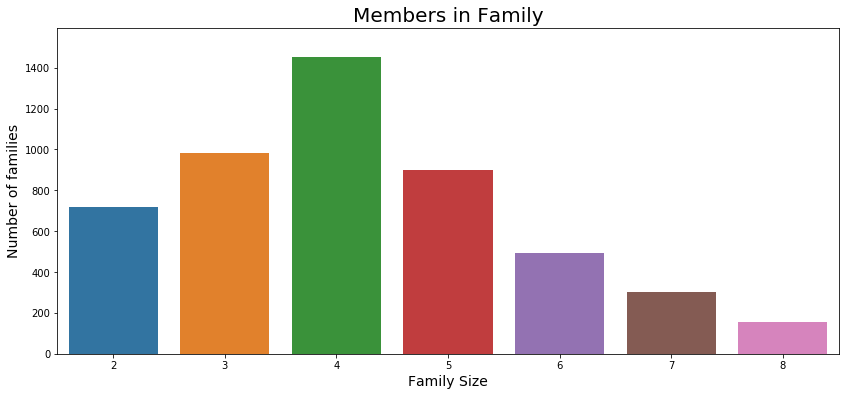

In [0]:
family_size = family_data['n_people'].value_counts().sort_index()


plt.figure(figsize=(14,6))
ax = sns.barplot(x=family_size.index, y=family_size.values)

ax.set_ylim(0, 1.1*max(family_size))
plt.xlabel('Family Size', fontsize=14)
plt.ylabel('Number of families', fontsize=14)
plt.title('Members in Family', fontsize=20)
plt.show()

Therefore, the share of really large families is small and it will not be a problem to choose the best days for them. 

Text(0.5, 1.0, 'Preferred Choice of each Family')

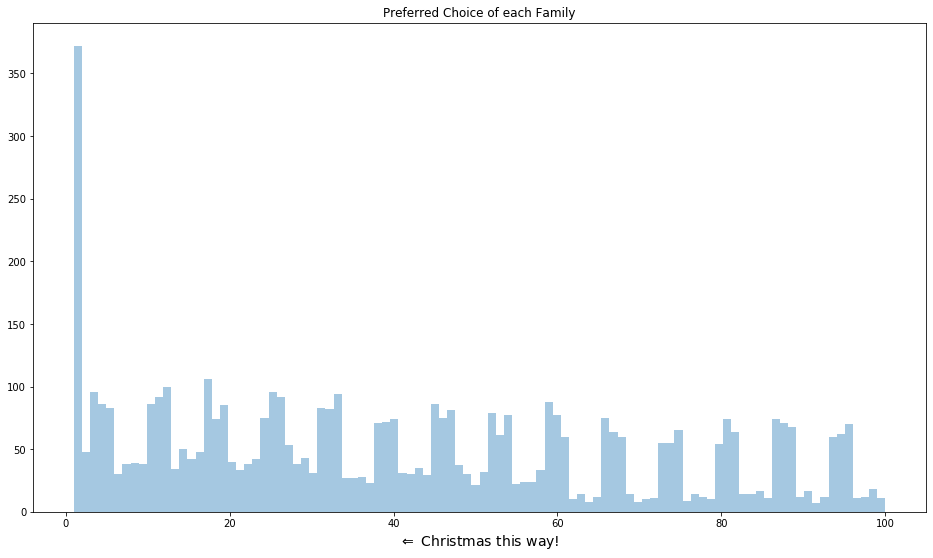

In [0]:
plt.figure(figsize=(16,9))
sns.distplot(family_data['choice_0'],bins=100,kde=False)
plt.xlabel('$\Leftarrow$ Christmas this way!', fontsize=14)
plt.title('Preferred Choice of each Family')

Text(0.5, 1.0, 'Least Preferred Choice for each Family')

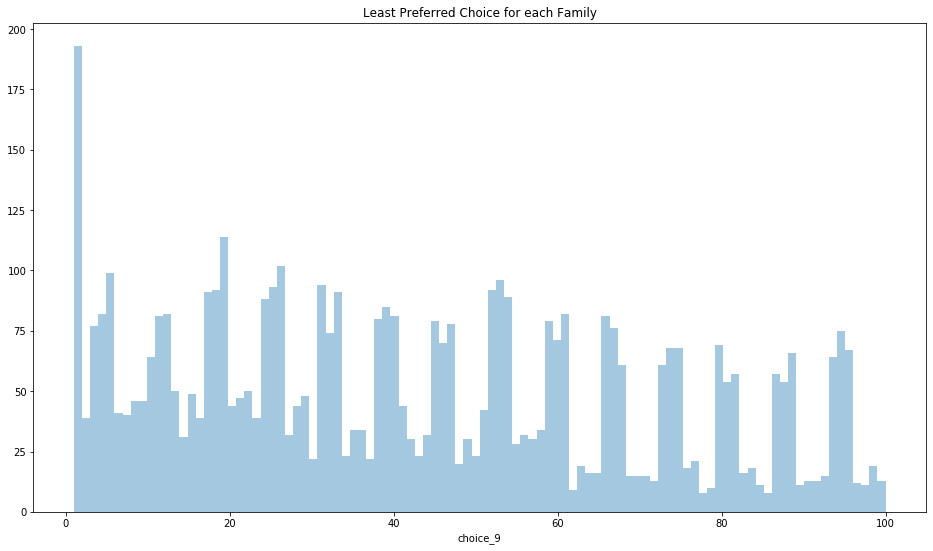

In [0]:
plt.figure(figsize=(16,9))
sns.distplot(family_data['choice_9'],bins=100,kde=False)
plt.title('Least Preferred Choice for each Family')

Text(0.5, 1.0, '5th Preferred Choice for each Family')

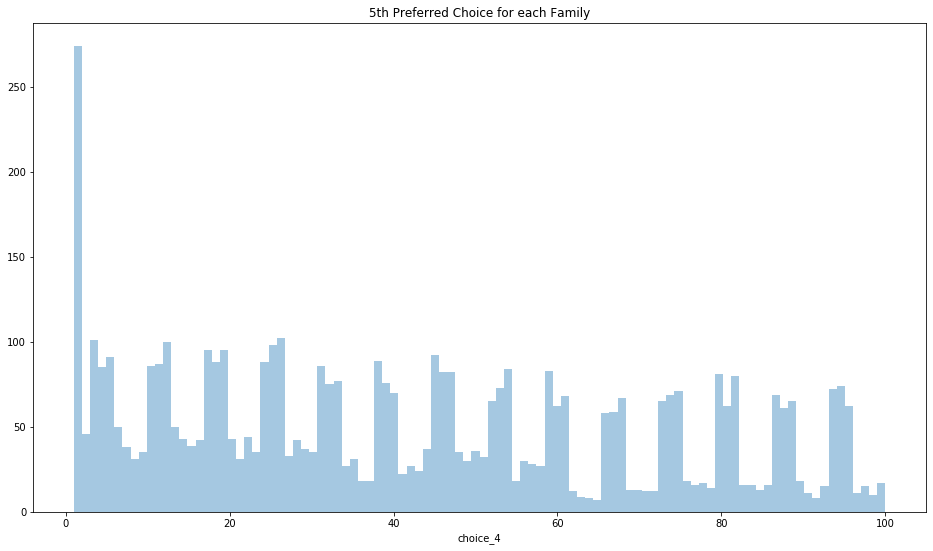

In [0]:
plt.figure(figsize=(16,9))
sns.distplot(family_data['choice_4'],bins=100,kde=False)
plt.title('5th Preferred Choice for each Family')

So the distribution of all choices is similar as most of tje families prefer either weekends or the day before Christmas. Also, the weekday wishes decrease towards the further days. 

There is no extra variables and no gaps in data. 

This problem hardly can be solved usind ML methods, however, I have to try.

Firstly, I'll try to predict the best days with kmeans.
Если бы можно было задать размеры кластеров (125-300 точек в кластере) и разделить все семьи на 100 кластеров, то номера этих кластеров были бы назначенными днями. И с учетом этих дней можно было бы посчитать затраты. (Но я не нашла информации, какими параметрами можно задать размеры кластера).

Можно попробовать построить регрессии и вычислить средние значения наилучшего дня для похожих семей, а потом считать затраты. (Но это у меня тоже не получилось)

In [0]:
data=pd.merge(family_data,submission,on='family_id',how='inner')
data
X=data.iloc[:,5:11]
y=data.loc[:,['assigned_day']]
X
y


,assigned_day
family_id,
0,52
1,26
2,100
3,2
4,53
...,...
4995,16
4996,88
4997,32


In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.20,random_state=0)


In [0]:
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
